## **Imports**

In [8]:
import re
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from googleapiclient.discovery import build
from youtube_transcript_api import YouTubeTranscriptApi
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

Matplotlib is building the font cache; this may take a moment.


## **API Key**

In [3]:
API_KEY = 'your_api_key'

## **Collect Video Info & Transcript**

In [6]:
def get_video_id(url):
    video_id_match = re.search(r'(?:v=|\/)([0-9A-Za-z_-]{11}).*', url)
    return video_id_match.group(1) if video_id_match else None

def get_video_title(video_id):
    # build the youtube service
    yt = build('youtube', 'v3', developerKey=API_KEY)

    # fetch the video details
    request = yt.videos().list(
        part = 'snippet',
        id = video_id
    )

    response = request.execute()

    # extract the video title
    title = response['items'][0]['snippet']['title'] if response['items'] else 'Unkown Title'
    return title

def get_video_transcript(video_id):
    try:
        transcript = YouTubeTranscriptApi.get_transcript(video_id)
        return transcript
    except Exception as e:
        print(f"An error occured: {e}")
        return []
    
def save_to_csv(title, transcript, filename):
    # Save the title & transcript to a CSV file
    transcript_data = [{'start': entry['start'], 'text': entry['text']} for entry in transcript]
    df = pd.DataFrame(transcript_data)
    df.to_csv(filename, index=False)

    # Save the title separately
    with open(filename, 'a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Title: ', title])


def main():
    url = input('Enter the Youtube Video Link: ')
    video_id = get_video_id(url)

    if not video_id:
        print('Invalid Youtube URL.')
        return
    
    title = get_video_title(video_id)
    transcript = get_video_transcript(video_id)

    if not transcript:
        print("No transcript available for this video...")
        return
    
    filename = f"{video_id}_transcript.csv"
    save_to_csv(title, transcript, filename)
    print(f"Transcript saved to {filename}")


# Execute
if __name__ == '__main__':
    main()

Transcript saved to STN2mLXr6lQ_transcript.csv


## **Analyze the Collected Data**

In [9]:
transcript_df = pd.read_csv('data/STN2mLXr6lQ_transcript.csv')
print(transcript_df)

       start                                      text
0       0.04     I'm going to be using rev.com all day
1      1.959      long just typing up captions banging
2        3.8       away on my keyboard mindlessly just
3       5.92     listening to audio and typing up what
4       7.72   I'm hearing and I'm going to see if you
..       ...                                       ...
147    307.0    was making about $25 an hour you could
148  308.919        do that for 1 hour or you can type
149    311.6                           captions for 10
150  316.199                                     hours
151  Title:   I Tried Typing Subtitles for $12 an Hour

[152 rows x 2 columns]


In [10]:
transcript_df['start'] = pd.to_numeric(transcript_df['start'], errors='coerce')

print('Dataset Overview:')
print(transcript_df.info())

print("\nBasic Statistics:")
print(transcript_df.describe())

Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152 entries, 0 to 151
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   start   151 non-null    float64
 1   text    152 non-null    object 
dtypes: float64(1), object(1)
memory usage: 2.5+ KB
None

Basic Statistics:
           start
count  151.00000
mean   148.35657
std     90.31793
min      0.04000
25%     71.19950
50%    148.28000
75%    220.07950
max    316.19900


- `Lets have a look at the Text Distribution`

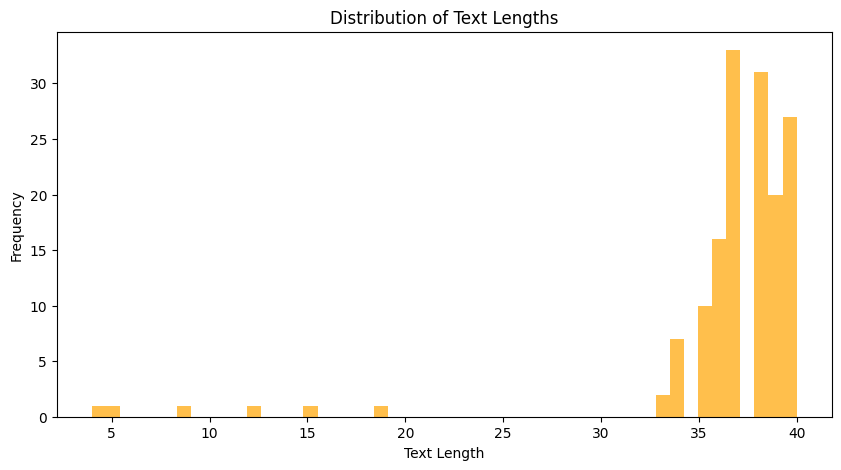

In [13]:
# Distribution of text lengths
transcript_df['text_length'] = transcript_df['text'].apply(len)
plt.figure(figsize=(10,5))
plt.hist(transcript_df['text_length'], bins=50, color='orange', alpha=0.7)
plt.title('Distribution of Text Lengths')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

- `Lets find the most commonly used words`

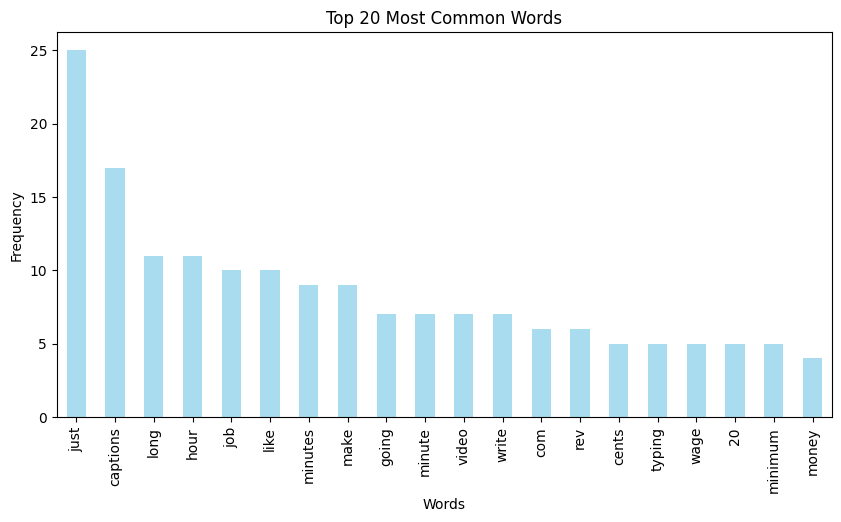

In [14]:
vec = CountVectorizer(stop_words='english')
word_counts = vec.fit_transform(transcript_df['text'])
word_counts_df = pd.DataFrame(word_counts.toarray(), columns=vec.get_feature_names_out())
common_words = word_counts_df.sum().sort_values(ascending=False).head(20)

plt.figure(figsize=(10,5))
common_words.plot(kind='bar', color='skyblue', alpha=0.7)
plt.title('Top 20 Most Common Words')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.show()

## **Perform Top Modeling**

In [15]:
# Using Non-negative Matrix Factorization (NMF)
n_features = 1000
n_topics = 10
n_top_words = 10

tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
tf = tf_vectorizer.fit_transform(transcript_df['text'])
nmf = NMF(n_components=n_topics, random_state=42).fit(tf)
tf_feature_names = tf_vectorizer.get_feature_names_out()

def display_topics(model, feature_names, no_top_words):
    topics = []
    for topic_idx, topic in enumerate(model.components_):
        topic_words = [feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]
        topics.append(" ".join(topic_words))
    return topics

topics = display_topics(nmf, tf_feature_names, n_top_words)
print("\nIdentified Topics:")
for i, topic in enumerate(topics):
    print(f"Topic {i+1}: {topic}")


Identified Topics:
Topic 1: just ve started want jobs cuz quite platform start away
Topic 2: captions written write typing youtube person 10 hours finished say
Topic 3: hour half took making reading typing cents sign did shift
Topic 4: job minimum wage working finished paid videos going day far
Topic 5: rev com video going wanted got day bit half start
Topic 6: minutes 20 cents 50 took pages focus ve far worth
Topic 7: long super going video ago style guide typing sign minutes
Topic 8: make money shift got did doing paid home oh work
Topic 9: minute write audio going video want ve gave cents time
Topic 10: like guide style pages people super bit half 20 rev


In [16]:
# Get topic distribution for each text segment
topic_distribution = nmf.transform(tf)

# Align the lengths by trimming the extra row in topic_distribution
trimmed = topic_distribution[:len(transcript_df)]

# compute the dominant topic for each text segment
transcript_df['dominant_topic'] = trimmed.argmax(axis=1)

In [17]:
logical_breaks = []

for i in range(1, len(transcript_df)):
    if transcript_df['dominant_topic'].iloc[i] != transcript_df['dominant_topic'].iloc[i-1]:
        logical_breaks.append(transcript_df['start'].iloc[i])

# Consolidate the logical breaks into broader chapters
threshold = 60      # seconds
consolidated_breaks = []
last_break = None

for break_point in logical_breaks:
    if last_break is None or break_point - last_break >= threshold:
        consolidated_breaks.append(break_point)
        last_break = break_point

# Merge consecutive breaks with the same dominant topic
final_chapters = []
last_chapter = (consolidated_breaks[0], transcript_df['dominant_topic'][0])

for break_point in consolidated_breaks[1:]:
    current_topic = transcript_df[transcript_df['start'] == break_point]['dominant_topic'].values[0]
    if current_topic == last_chapter[1]:
        last_chapter = (last_chapter[0], current_topic)
    else:
        final_chapters.append(last_chapter)
        last_chapter = (break_point, current_topic)

final_chapters.append(last_chapter)  # append the last chapter

## **Final Steps**

In [18]:
# Convert the final chapters to a readable time format
chapter_points = []
chapter_names = []

for i, (break_point, topic_idx) in enumerate(final_chapters):
    chapter_time = pd.to_datetime(break_point, unit='s').strftime('%H:%M:%S')
    chapter_points.append(chapter_time)

    # get the context for the chapter name
    chapter_text = transcript_df[(transcript_df['start'] >= break_point) & (transcript_df['dominant_topic'] == topic_idx)]['text'].str.cat(sep=' ')

    # extract key phrases to create a chapter name
    vectorizer = TfidfVectorizer(stop_words='english', max_features=3)
    tfidf_matrix = vectorizer.fit_transform([chapter_text])
    feature_names = vectorizer.get_feature_names_out()
    chapter_name = " ".join(feature_names)

    chapter_names.append(f"Chapter {i+1}: {chapter_name}")

# display the final chapter points with names
print("\nFinal Chapter Points with Names:")
for time, name in zip(chapter_points, chapter_names):
    print(f"{time} - {name}")


Final Chapter Points with Names:
00:00:01 - Chapter 1: com rev video
00:01:02 - Chapter 2: accepted long minutes
00:02:03 - Chapter 3: got make work
00:03:04 - Chapter 4: able going minute
00:05:11 - Chapter 5: 10 captions hours


`In the above code, we are converting the final chapter breakpoints into a readable time format and generating meaningful names for each chapter.`

### **Summary**
So, this is how Video Chaptering works.